In [1]:
import os
import openai
from dotenv import load_dotenv, find_dotenv

_ = load_dotenv(find_dotenv()) 
openai.api_key  = os.getenv('OPENAI_API_KEY')

## This is Causal Flow for GRC Policy

- This is created from domain knowledge of the GRC engineers
- At some point, we could expect to derive this from reading of code
- If so, it will help streamline things even more

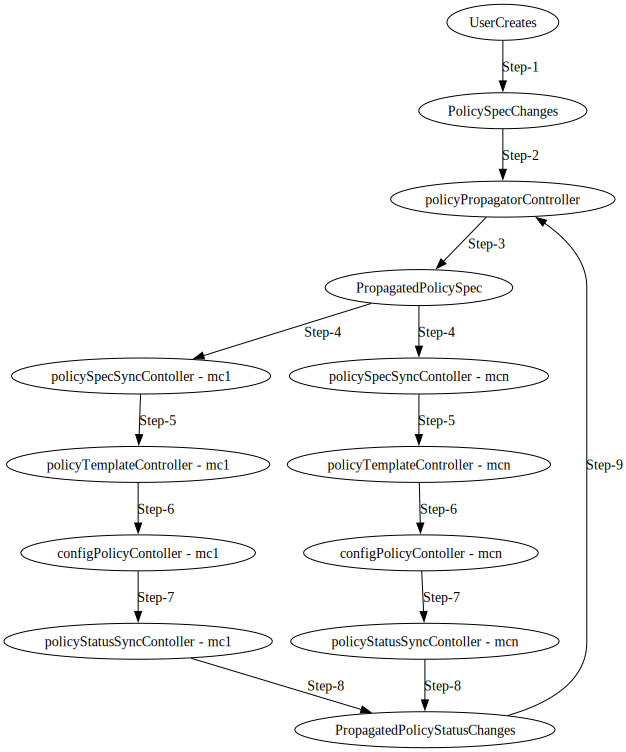

In [2]:
import networkx as nx
import graphviz


acmpolicycomplete=graphviz.Digraph()

acmpolicycomplete.edge('UserCreates','PolicySpecChanges', label="Step-1")
acmpolicycomplete.edge('PolicySpecChanges','policyPropagatorController', label="Step-2")
#acmpolicycomplete.edge('PolicyStatusChanges','PropagatedPolicyStatus')
#acmpolicycomplete.edge('policyPropagatorController','WorkQueueDepth', label="Step-3")
acmpolicycomplete.edge('policyPropagatorController','PropagatedPolicySpec', label="Step-3")


acmpolicycomplete.edge('PropagatedPolicySpec','policySpecSyncContoller - mc1', label="Step-4")
acmpolicycomplete.edge('PropagatedPolicySpec','policySpecSyncContoller - mcn', label="Step-4")

acmpolicycomplete.edge('policySpecSyncContoller - mc1','policyTemplateController - mc1', label="Step-5")
acmpolicycomplete.edge('policySpecSyncContoller - mcn','policyTemplateController - mcn', label="Step-5")

acmpolicycomplete.edge('policyTemplateController - mc1','configPolicyContoller - mc1', label="Step-6")
acmpolicycomplete.edge('policyTemplateController - mcn','configPolicyContoller - mcn', label="Step-6")

acmpolicycomplete.edge('configPolicyContoller - mc1','policyStatusSyncContoller - mc1', label="Step-7")
acmpolicycomplete.edge('configPolicyContoller - mcn','policyStatusSyncContoller - mcn', label="Step-7")

acmpolicycomplete.edge('policyStatusSyncContoller - mc1','PropagatedPolicyStatusChanges', label="Step-8")
acmpolicycomplete.edge('policyStatusSyncContoller - mcn','PropagatedPolicyStatusChanges', label="Step-8")

acmpolicycomplete.edge('PropagatedPolicyStatusChanges','policyPropagatorController', label="Step-9")

acmpolicycomplete

## Enter LLM

- A GRC Engineer, uses the above causal graph in his/her head to answer amazingly complex questions
- Let us see if we feed the same information to LLM, how well it does

In [3]:
GRC_PROMPT = """You are an expert at answering questions about a topology, \
such as the relationships between nodes, paths, connectivity, and other related queries \
You will be provided the topology as a  Graphviz digraph : {composition}. \
Answer the question based on the above topology.\
A few other things to keep in mind: \
Nodes which has names ending with "-mc*" means they happen on a managed cluster. \
Nodes that does not end by that are running on the hub cluster. \
Needless to say, the hub cluster manages the "managed" cluster."""

#### Just taking the GRC causal graph and adding it to LLM as a prompt.

- There is probably is a more elegant way to do this other than cut pasting!
- Let us also see if this is more effective in answering questions than using:
    - the same causal knowledge graph in graph databse
    - with a graphdb agent with LLM

In [4]:
composition = """
acmpolicycomplete=graphviz.Digraph()\

acmpolicycomplete.edge('UserCreates','PolicySpecChanges', label="Step-1")\
acmpolicycomplete.edge('PolicySpecChanges','policyPropagatorController', label="Step-2")\
#acmpolicycomplete.edge('PolicyStatusChanges','PropagatedPolicyStatus')\
#acmpolicycomplete.edge('policyPropagatorController','WorkQueueDepth', label="Step-3")\
acmpolicycomplete.edge('policyPropagatorController','PropagatedPolicySpec', label="Step-3")\


acmpolicycomplete.edge('PropagatedPolicySpec','policySpecSyncContoller - mc1', label="Step-4")\
acmpolicycomplete.edge('PropagatedPolicySpec','policySpecSyncContoller - mcn', label="Step-4")\

acmpolicycomplete.edge('policySpecSyncContoller - mc1','policyTemplateController - mc1', label="Step-5")\
acmpolicycomplete.edge('policySpecSyncContoller - mcn','policyTemplateController - mcn', label="Step-5")\

acmpolicycomplete.edge('policyTemplateController - mc1','configPolicyContoller - mc1', label="Step-6")\
acmpolicycomplete.edge('policyTemplateController - mcn','configPolicyContoller - mcn', label="Step-6")\

acmpolicycomplete.edge('configPolicyContoller - mc1','policyStatusSyncContoller - mc1', label="Step-7")\
acmpolicycomplete.edge('configPolicyContoller - mcn','policyStatusSyncContoller - mcn', label="Step-7")\

acmpolicycomplete.edge('policyStatusSyncContoller - mc1','PropagatedPolicyStatusChanges', label="Step-8")\
acmpolicycomplete.edge('policyStatusSyncContoller - mcn','PropagatedPolicyStatusChanges', label="Step-8")\

acmpolicycomplete.edge('PropagatedPolicyStatusChanges','policyPropagatorController', label="Step-9")\

acmpolicycomplete\
"""

In [5]:
msgs = ["After the user creates a policy on the hub cluster, how does it propagate to the managed cluster",
       "The user is saying they do not see the policy being propagated - they are looking at the hub server only. \
        Can you suggest what may have gone wrong. Say outline 3 possible causes in order of likelihood"
      ]

In [6]:
from langchain_openai import ChatOpenAI
from langchain_core.messages import AnyMessage, SystemMessage, HumanMessage, AIMessage, ChatMessage

In [7]:
for msg in msgs:
    messages = [
            SystemMessage(content=GRC_PROMPT.format(composition=composition)), 
            HumanMessage(content=msg)        
       ]

    # The quality of answer from gpt-4 is much better than gpt-3.5-turbo
    # This is probably because we are using LLM's strength to understand 
    # topological data.
    model = ChatOpenAI(model="gpt-4", temperature=0)
    response = model.invoke(messages)
    print("")
    print("--------------")
    print(msg)
    print("--------------")
    print(response.content)


--------------
After the user creates a policy on the hub cluster, how does it propagate to the managed cluster
--------------
After the user creates a policy on the hub cluster, the following steps occur for it to propagate to the managed cluster:

1. The policy specification changes (PolicySpecChanges).

2. The policy propagator controller (policyPropagatorController) on the hub cluster picks up these changes.

3. The policy propagator controller then propagates the policy specification (PropagatedPolicySpec).

4. The propagated policy specification is then picked up by the policy specification sync controller (policySpecSyncContoller - mc*) on the managed cluster.

5. The policy specification sync controller then passes the policy to the policy template controller (policyTemplateController - mc*).

6. The policy template controller then passes the policy to the configuration policy controller (configPolicyContoller - mc*).

7. The configuration policy controller then passes the pol